<a href="https://colab.research.google.com/github/Aaditya-S6/IIT-BHU-Summer-Internship-Network-Security/blob/main/Mobile_App_Traffic_Classification_Using_Graphormer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q -U datasets transformers>=4.27.2 Cython

In [2]:
from transformers.utils import is_cython_available
print("Cython is installed:", is_cython_available())

Cython is installed: True


In [3]:
!pip install -q -U matplotlib networkx

In [24]:
from huggingface_hub import notebook_login

notebook_login()

In [5]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store


In [6]:
from datasets import load_dataset

dataset = load_dataset("Aaditya1/Mobile_Application_Traffic_Data")
dataset = dataset.shuffle(seed=0)
dataset['train']  = dataset['train'].select(range(1000))
dataset = dataset.shuffle(seed=0)
dataset['validation']=dataset['validation'].select(range(200))
dataset = dataset.shuffle(seed=0)
dataset['test']=dataset['test'].select(range(500))

dataset

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['edge_index', 'edge_attr', 'y', 'num_nodes', 'node_feat'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['edge_index', 'edge_attr', 'y', 'num_nodes', 'node_feat'],
        num_rows: 200
    })
    test: Dataset({
        features: ['edge_index', 'edge_attr', 'y', 'num_nodes', 'node_feat'],
        num_rows: 500
    })
})

In [7]:
from datasets import load_metric

metric = load_metric("accuracy")

<ipython-input-7-350fcae91df9>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [8]:
print(dataset["train"][0])

{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 3, 5, 5, 6, 6, 7, 3, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 1, 14, 14, 15, 13, 8], [1, 0, 2, 1, 3, 2, 4, 3, 5, 3, 6, 5, 7, 6, 8, 3, 9, 8, 10, 9, 11, 10, 12, 11, 13, 12, 14, 1, 15, 14, 8, 13]], 'edge_attr': [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [1, 0, 1], [1, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 0], [0, 0, 0], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [1, 0, 1], [1, 0, 1], [0, 0, 1], [0, 0, 1], [3, 0, 1], [3, 0, 1]], 'y': [0], 'num_nodes': 16, 'node_feat': [[5, 0, 4, 5, 3, 0, 2, 0, 0], [5, 0, 3, 5, 0, 0, 1, 0, 0], [5, 0, 4, 5, 2, 0, 2, 0, 0], [5, 0, 4, 5, 0, 0, 2, 0, 0], [7, 0, 2, 5, 1, 0, 2, 0, 0], [5, 0, 3, 5, 1, 0, 1, 0, 0], [6, 0, 2, 5, 0, 0, 1, 0, 0], [7, 0, 2, 5, 1, 0, 1, 0, 0], [5, 0, 3, 5, 0, 0, 1, 1, 1], [5, 0, 3, 5, 1, 0, 1, 1, 1], [5, 0, 3, 5, 1, 0, 1, 1, 1], [5, 0, 3, 5, 1, 0, 1, 1, 1], [5, 0, 3,

In [9]:
print(dataset["test"][0])

{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 1, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 13, 25, 25, 26, 9, 5, 26, 10, 24, 16, 23, 18], [1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8, 10, 1, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15, 17, 16, 18, 17, 19, 18, 20, 19, 21, 20, 22, 21, 23, 22, 24, 23, 25, 13, 26, 25, 5, 9, 10, 26, 16, 24, 18, 23]], 'edge_attr': [[1, 0, 1], [1, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [1, 0, 1], [1, 0, 1], [0, 0, 1], [0, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [0, 0, 1], [0, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1],

In [10]:
print(dataset["validation"][0])

{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 3, 10, 10, 11, 11, 12, 10, 13, 13, 14, 13, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 16, 1, 22, 17, 9, 4], [1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8, 10, 3, 11, 10, 12, 11, 13, 10, 14, 13, 15, 13, 16, 15, 17, 16, 18, 17, 19, 18, 20, 19, 21, 20, 22, 21, 1, 16, 17, 22, 4, 9]], 'edge_attr': [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [1, 0, 1], [1, 0, 1], [0, 0, 1], [0, 0, 1], [2, 0, 1], [2, 0, 1], [0, 0, 1], [0, 0, 1], [1, 0, 1], [1, 0, 1], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1], [0, 0, 0], [0, 0, 0], [3, 0, 1], [3, 0, 1], [3, 0, 1], [3, 0, 1]], 'y': [0], 'num_nodes': 23, 'node_feat': [[5, 0, 4, 5, 3, 0

In [11]:
dataset["train"].features

{'edge_index': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'edge_attr': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'y': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'num_nodes': Value(dtype='int64', id=None),
 'node_feat': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None)}

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

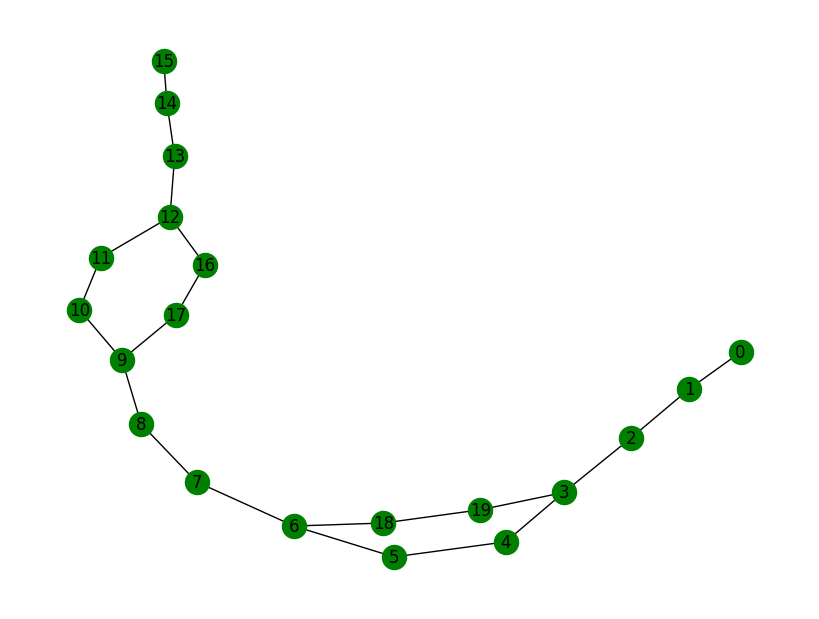

In [13]:
graph = dataset["train"][1]
edges = graph["edge_index"]
num_edges = len(edges[0])
num_nodes = graph["num_nodes"]

# Conversion to networkx format
G = nx.Graph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from([(edges[0][i], edges[1][i]) for i in range(num_edges)])

# Plot
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='green', edge_color='black')
plt.show()


In [14]:
print("Label:", graph['y'])

Label: [0]


In [15]:
from transformers.models.graphormer.collating_graphormer import preprocess_item, GraphormerDataCollator

dataset_processed = dataset.map(preprocess_item, batched=False)

In [16]:
# split up training into training + validation
train_ds = dataset_processed['train']
val_ds = dataset_processed['validation']

In [17]:
! pip install -U accelerate
! pip install -U transformers

In [18]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.30.2', '0.20.3')

In [19]:
from transformers import GraphormerForGraphClassification

model_checkpoint = "clefourrier/graphormer-base-pcqm4mv2" # pre-trained model from which to fine-tune

model = GraphormerForGraphClassification.from_pretrained(
    model_checkpoint,
    num_classes=2,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of GraphormerForGraphClassification were not initialized from the model checkpoint at clefourrier/graphormer-base-pcqm4mv2 and are newly initialized because the shapes did not match:
- classifier.classifier.weight: found shape torch.Size([1, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    "graph-classification",
    logging_dir="graph-classification",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    auto_find_batch_size=True, # batch size can be changed automatically to prevent OOMs
    gradient_accumulation_steps=10,
    dataloader_num_workers=0,
    num_train_epochs=10,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    push_to_hub=False,
)

In [21]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=GraphormerDataCollator()
)

In [22]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Epoch,Training Loss,Validation Loss
0,0.745200,0.152794
1,0.157500,0.106542
2,0.176000,0.106400
3,0.166900,0.355273
4,0.186500,0.097586
5,0.154400,0.105283
6,0.126800,0.097279
7,0.145000,0.100528
8,0.139500,0.099638
9,0.115400,0.099139


***** train metrics *****
  epoch                    =       9.52
  total_flos               =        0GF
  train_loss               =     0.2124
  train_runtime            = 2:14:26.80
  train_samples_per_second =       1.24
  train_steps_per_second   =      0.007


In [31]:
eval_results = trainer.evaluate(eval_dataset=val_ds)


# Access the evaluation metrics
#eval_metrics = eval_results.metrics

# Print the evaluation metrics
print("Evaluation Metrics:")
for key, value in eval_results.items():
    print(f"{key}: {value}")

Evaluation Metrics:
eval_loss: 0.09913870692253113
eval_runtime: 139.6603
eval_samples_per_second: 1.432
eval_steps_per_second: 0.093
epoch: 9.52


In [25]:
#@title
trainer.push_to_hub()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 2>:2                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3716 in push_to_hub              │
│                                                                                                  │
│   3713 │   │   # If a user calls manually `push_to_hub` with `self.args.push_to_hub = False`, w  │
│   3714 │   │   # it might fail.                                                                  │
│   3715 │   │   if not hasattr(self, "repo"):                                                     │
│ ❱ 3716 │   │   │   self.init_git_repo()                                                          │
│   3717 │   │                                                                                     │
│   3718 │   │   model_name = kwargs.pop("model_name", None)                                       │
│   3719 │   │   if model_name is None and self.args.should_save:                                  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3571 in init_git_repo            │
│                                                                                                  │
│   3568 │   │   # Make sure the repo exists.                                                      │
│   3569 │   │   create_repo(repo_name, token=self.args.hub_token, private=self.args.hub_private_  │
│   3570 │   │   try:                                                                              │
│ ❱ 3571 │   │   │   self.repo = Repository(self.args.output_dir, clone_from=repo_name, token=sel  │
│   3572 │   │   except EnvironmentError:                                                          │
│   3573 │   │   │   if self.args.overwrite_output_dir and at_init:                                │
│   3574 │   │   │   │   # Try again after wiping output_dir                                       │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_validators.py:118 in _inner_fn    │
│                                                                                                  │
│   115 │   │   if check_use_auth_token:                                                           │
│   116 │   │   │   kwargs = smoothly_deprecate_use_auth_token(fn_name=fn.__name__, has_token=ha   │
│   117 │   │                                                                                      │
│ ❱ 118 │   │   return fn(*args, **kwargs)                                                         │
│   119 │                                                                                          │
│   120 │   return _inner_fn  # type: ignore                                                       │
│   121                                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/huggingface_hub/repository.py:516 in __init__            │
│                                                                                                  │
│    513 │   │   │   self.huggingface_token = HfFolder.get_token()                                 │
│    514 │   │                                                                                     │
│    515 │   │   if clone_from is not None:                                                        │
│ ❱  516 │   │   │   self.clone_from(repo_url=clone_from)                                          │
│    517 │   │   else:                                       